In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sys.path.append('../..')
sys.path.append('../classification/')

from tqdm import tqdm
from faster_rcnn import RPNModel
from dataset.dataset.image import ImagesBatch
from dataset import Dataset, DatasetIndex, B, V
from detection_mnist import DetectionMnist
%matplotlib inline

In [2]:
IMAGE_SHAPE = (64, 64)
MAP_SHAPE = (8, 8)
N_ANCHORS = MAP_SHAPE[0] * MAP_SHAPE[1] * 9
MNIST_PER_IMAGE = 5
BATCH_SIZE = 64

In [18]:
ind = DatasetIndex(np.arange(65000))          
mnist = Dataset(ind, batch_class=DetectionMnist)   
mnist.cv_split([0.9, 0.1]) 

In [19]:
placeholders_config = {
                       'images': {'shape': IMAGE_SHAPE + (1,),
                                 'dtype': 'float32',
                                 'data_format': 'channels_last',
                                 'name': 'reshaped_images'},
                       }

In [20]:
model_config = {'inputs': placeholders_config,
                'batch_norm': True,
                'optimizer': 'Adam'}

In [21]:
train_feed_dict = {'images': B('images'),
                   'proposal_targets': B('clsf'),
                   'bbox_targets': B('reg')}        

test_feed_dict = {'images': B('images'),
                   'proposal_targets': B('clsf'),
                   'bbox_targets': B('reg')}  

In [22]:
train_pp = (mnist.train.p
            .init_model('static', RPNModel, 'rpn', config=model_config)
            .init_variable('loss_history', init_on_each_run=list)
            .init_variable('IoU_predictions', init_on_each_run=list)
            .load_images()
            .generate_multimnist_images(image_shape=IMAGE_SHAPE, max_dig=MNIST_PER_IMAGE)
            .create_anchors(IMAGE_SHAPE, MAP_SHAPE)
            .create_reg_cls()
            .param_reg()
            .train_model('rpn', 
                         fetches=['loss', 'reg_loss', 'cls_loss'],
                         feed_dict=train_feed_dict,
                         save_to=V('loss_history'), 
                         mode='a'
            ))

In [23]:
test_pp = (mnist.test.p
            .import_model('rpn', train_pp)
            .init_variable('loss_history', init_on_each_run=list)
            .load_images()
            .generate_multimnist_images(image_shape=IMAGE_SHAPE, max_dig=MNIST_PER_IMAGE)
            .create_anchors(IMAGE_SHAPE, MAP_SHAPE)
            .create_reg_cls()
            .param_reg()
            .predict_model('rpn', 
                           fetches=['RoI', 'IoU'],
                           feed_dict=test_feed_dict,
                           save_to=[B('roi_predictions'), B('iou_predictions')],
                           )
            .predict_model('rpn', 
                         fetches=['loss', 'reg_loss', 'cls_loss'],
                         feed_dict=train_feed_dict,
                         save_to=V('loss_history'), 
                         mode='a')
            .unparam_predictions())

In [24]:
for i in tqdm(range(1000)):
    train_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    test_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    #if (i+1) % 10 == 0:
        #print(batch.data.bbox_batch_sizes)
        #print('Iter {}: {}'.format(i+1, train_pp.get_variable('loss_history')[-1]))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:43<00:00,  1.06it/s]


In [25]:
reg_loss = np.array(train_pp.get_variable('loss_history'))[:,1]
cls_loss = np.array(train_pp.get_variable('loss_history'))[:,2]
total_loss = np.array(train_pp.get_variable('loss_history'))[:,0]

test_reg_loss = np.array(test_pp.get_variable('loss_history'))[:,1]
test_cls_loss = np.array(test_pp.get_variable('loss_history'))[:,2]
test_total_loss = np.array(test_pp.get_variable('loss_history'))[:,0]

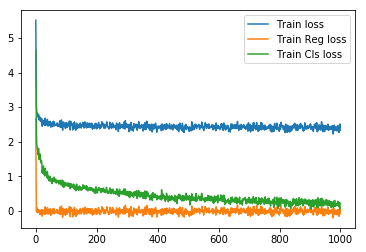

In [26]:
plt.plot(np.log(total_loss), label='Train loss')
plt.plot(np.log(reg_loss), label='Train Reg loss')
plt.plot(np.log(cls_loss), label='Train Cls loss')
plt.legend()

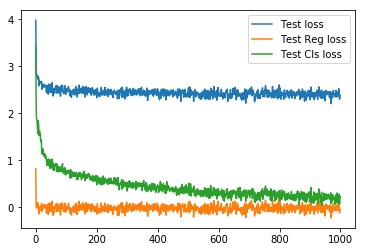

In [27]:
plt.plot(np.log(test_total_loss), label='Test loss')
plt.plot(np.log(test_reg_loss), label='Test Reg loss')
plt.plot(np.log(test_cls_loss), label='Test Cls loss')
plt.legend()

In [28]:
batch = test_pp.next_batch(BATCH_SIZE, n_epochs=None)

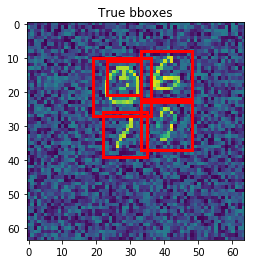

In [29]:
i = 1
im = batch.data.images[i]
bboxes = batch.data.bboxes[i]

fig, ax = plt.subplots(1)

ax.imshow(im)

for bbox in bboxes:    
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[2], bbox[3] ,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.title('True bboxes')
plt.show()

In [ ]:
i = 10
im = batch.data.images[i]
bboxes = batch.data.anchors[batch.data.clsf[i] == 1]

fig, ax = plt.subplots(1)

ax.imshow(im)

for bbox in bboxes:    
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[2], bbox[3] ,linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.title('Best anchors')
plt.show()

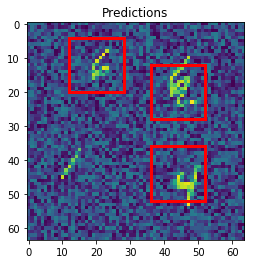

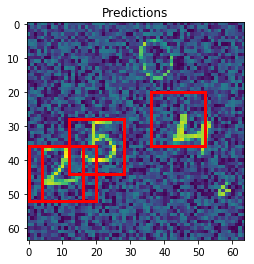

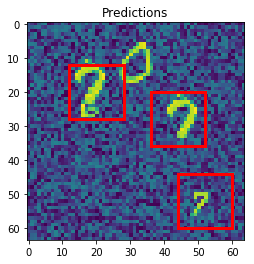

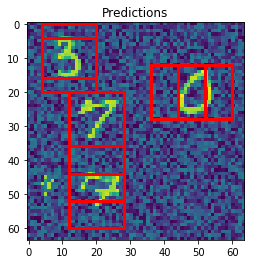

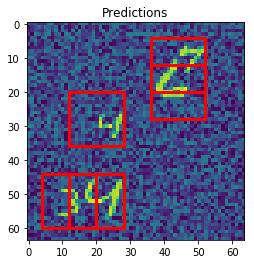

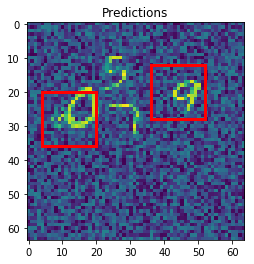

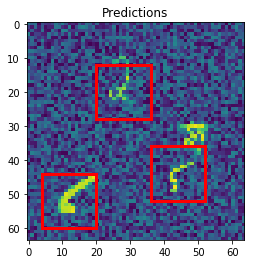

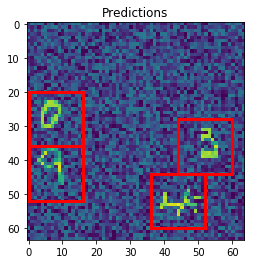

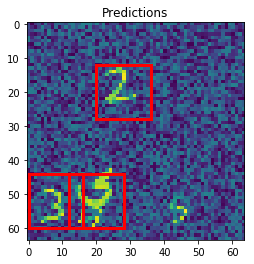

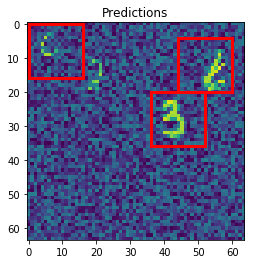

In [17]:
for i in range(50, 60):
    im = batch.data.images[i]
    bboxes = batch.data.roi_predictions[i]
    selected_RoI = batch.data.iou_predictions[i]

    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for bbox in bboxes[selected_RoI > 0.3]:    
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[2], bbox[3], linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title('Predictions')
    plt.show()